# Avaliando o impacto de uma política pública: **Desenho de Regressão Descontínua** (*RDD*)

## Programa de Subsídios a Planos de Saúde (*Health Insurance Subsidy Program - HISP*)

Objetivo primário do programa: reduzir a despesa com itens relacionados a saúde para domicílios de baixa renda.

Variável de interesse: *health_expenditures*

----

## Leitura dos Dados

In [1]:
## Já instalando bibliotecas necessárias
from IPython.display import clear_output # limpa o output de uma célula
!pip install linearmodels

clear_output()  # limpando o texto

In [2]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import ols
from patsy import dmatrices

In [3]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
## Lendo os dados
sCaminho = "/content/drive/Othercomputers/Meu modelo MacBook Air/Documents/IPEA/Curso IDP/Avaliação de Impacto de Políticas - World Bank/Dados/"
sArquivo = "evaluation.dta"

## Lendo o DataFrame
df = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 19827; Colunas: 22


In [5]:
## Vendo a descrição das variáveis (só funciona com arquivos .dta)
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader
stata_reader = pd.read_stata(f"{sCaminho}{sArquivo}", iterator=True)

# Pegando as descrições das variáveis
descricoes = stata_reader.variable_labels()
descricoes

{'age_hh': 'Age of the head of the household (in years)',
 'age_sp': 'Age of the spouse (in years)',
 'bathroom': 'Home with private bathroom at baseline (0=no, 1=yes)',
 'dirtfloor': 'Home has a dirt floor at baseline (0=no, 1=yes)',
 'educ_hh': 'Education of the head of household (completed years of schooling)',
 'educ_sp': 'Education of the spouse (completed years of schooling)',
 'eligible': 'Household eligible to enroll in HISP (0=no, 1=yes)',
 'enrolled': 'HH enrolled in HISP (0=no, 1=yes)',
 'enrolled_rp': 'Household enrolled in HISP under the random promotion scenario (0=no, 1=yes)',
 'female_hh': 'Head of the household is a woman (0=no, 1=yes)',
 'health_expenditures': 'Out of pocket health expenditures (per person per year)',
 'hhsize': 'Number of household members (baseline)',
 'hospital': 'HH member visited hospital in the past year (0=no, 1=yes)',
 'hospital_distance': 'Distance to closest hospital',
 'household_identifier': 'Unique household identifier',
 'indigenous': 'H

In [6]:
## Vendo o DataFrame
df.head(10)

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
0,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,0.0,15.185455,24.0,23.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
1,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,1.0,19.580902,25.0,24.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
2,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,0.0,13.076257,30.0,26.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,0.0
3,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,1.0,2.398854,31.0,27.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,1.0
4,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,1.0,0.000000,59.0,57.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,1.0
5,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,0.0,15.286353,58.0,56.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,0.0
6,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,1.0,20.026909,36.0,25.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
7,26.0,16.0,1.0,1.0,1.0,1.0,1.0,56.903400,0.0,11.311761,35.0,24.0,3.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
8,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,0.0,11.223912,37.0,35.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0
9,26.0,21.0,1.0,1.0,1.0,1.0,1.0,46.908810,1.0,16.664686,39.0,36.0,0.0,0.0,0.0,0.0,7.0,1,0,2,124.819966,0.0


In [7]:
## Descrevendo o DataFrame
df.describe()

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
count,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,11257.000000
mean,73.933472,8038.965820,0.500277,0.512685,0.567761,0.299037,0.293287,56.789505,0.500025,17.035103,46.683117,40.581734,2.833550,2.618601,0.099057,0.352903,5.178645,0.603621,0.615978,2.079740,105.322517,0.052323
std,55.076599,4569.468262,0.500017,0.499851,0.495377,0.457822,0.455238,10.686106,0.500013,9.291589,15.294811,12.822810,2.754772,2.543370,0.298730,0.477869,2.195178,0.489157,0.486375,3.133202,42.063479,0.222696
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.479134,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.465392,0.000000
25%,30.000000,3989.500000,0.000000,0.000000,0.000000,0.000000,0.000000,49.652241,0.000000,11.621977,34.000000,31.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,72.804218,0.000000
50%,59.000000,8040.000000,1.000000,1.000000,1.000000,0.000000,0.000000,56.414219,1.000000,16.051678,45.000000,41.000000,2.000000,2.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,113.556497,0.000000
75%,112.000000,12033.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.905720,1.000000,21.236842,58.000000,48.000000,4.000000,4.000000,0.000000,1.000000,7.000000,1.000000,1.000000,3.000000,141.097735,0.000000
max,200.000000,15778.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000,116.830643,88.000000,88.000000,16.000000,17.000000,1.000000,1.000000,13.000000,1.000000,1.000000,23.000000,170.457647,1.000000


In [8]:
## Vendo média de gastos com saúde por período
df.groupby('round')['health_expenditures'].mean()

round
0.0    17.210985
1.0    16.859217
Name: health_expenditures, dtype: float32

In [9]:
## Criando lista e fórmula com controles
# Lista
lControles = ["age_hh", "age_sp", "educ_hh", "educ_sp", "female_hh", "indigenous",
              "hhsize", "dirtfloor", "bathroom", "land", "hospital_distance"]

# Formulas
sControles = "age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance"

## Regressão Descontínua

Além de selecionar aleatoriamente os povoados que serão submetidos ao programa (*treatment_locality == 1*), o Ministério da Saúde também direcionou o HISP exclusivamente às famílias de baixa renda, utilizando a linha de pobreza nacional (*poverty_index*) como parâmetro. 

O índice varia de 20 a 100, sendo **58** a linha de pobreza; mesmo nos povoados de tratamento, apenas as famílias pobres são elegíveis para se inscrever no HISP.

Dessa forma, note que a linha de pobreza é um índice contínuo, mas ainda temos que verificar a densidade desse índice (para ver se há alguma manipulação) e verificar se há cumprimento parcial; se for o caso, teremos que usar uma estratégia *fuzzy*, com o uso de variáveis instrumentais.

In [10]:
## Selecionando apenas os dados relevantes
dfTratados = df.query('treatment_locality == 1').copy()

In [11]:
nPobreza = 58

## Determinando quais são os domicílios pobres
dfTratados['pobre'] = np.where(dfTratados['poverty_index'] <= nPobreza, 1, 0)

## Normalizando o índice de pobreza
# Pessoas abaixo de 0 são consideradas pobres
dfTratados['poverty_index_norm'] = dfTratados['poverty_index'] - nPobreza

## Vendo os resultados
dfTratados[['poverty_index', 'pobre', 'poverty_index_norm', 'eligible']]

,poverty_index,pobre,poverty_index_norm,eligible
0,55.950542,1,-2.049458,1.0
1,55.950542,1,-2.049458,1.0
2,46.058731,1,-11.941269,1.0
3,46.058731,1,-11.941269,1.0
4,54.095825,1,-3.904175,1.0
...,...,...,...,...
19778,66.846985,0,8.846985,0.0
19823,62.055641,0,4.055641,0.0
19824,62.055641,0,4.055641,0.0
19825,62.828438,0,4.828438,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(58.5, 0.041, 'Linha de pobreza: 58')

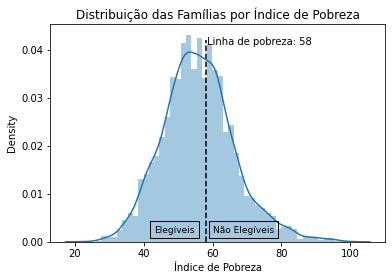

In [12]:
## Vendo se há alguma manipulação em torno da linha de corte do programa usando um gráfico de densidade
# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)
# Histograma e densidade (note o round == 0)
gDensidade = sns.distplot(dfTratados.query('round == 0')['poverty_index'], axlabel="Índice de Pobreza")
# Linha vertical pontilhada
plt.vlines(x=nPobreza, ymin=0, ymax=0.042, linestyles='dashed')
# Título
plt.title("Distribuição das Famílias por Índice de Pobreza")
# Anotações
plt.annotate("Elegíveis", xy=(49, 0.002), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=9)
plt.annotate("Não Elegíveis", xy=(69, 0.002), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=9)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(58.5, 0.041), fontsize=10)

Text(58.5, 0.6, 'Linha de pobreza: 58')

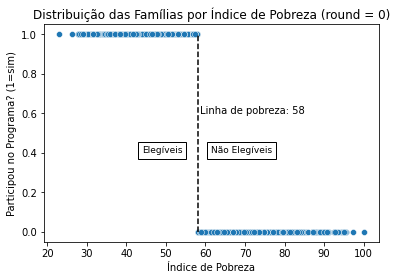

In [13]:
## Apesar de haver uma barra maior logo antes do corte, há uma também logo após:
## combinado com a linha contínua, não parece haver manipulação

## Temos que ver agora se há cumprimento total (ou seja, se cada família respeita sua alocação)
# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)
# Pontos
gPontos = sns.scatterplot(data=dfTratados.query('round == 0'),
                          x='poverty_index',
                          y='enrolled')
# Linha vertical pontilhada
plt.vlines(x=nPobreza, ymin=0, ymax=1, linestyles='dashed')
# Título
plt.title("Distribuição das Famílias por Índice de Pobreza (round = 0)")
plt.xlabel("Índice de Pobreza")
plt.ylabel("Participou no Programa? (1=sim)")
# Anotações
plt.annotate("Elegíveis", xy=(49, 0.4), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=9)
plt.annotate("Não Elegíveis", xy=(69, 0.4), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=9)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(58.5, 0.6), fontsize=10)

## Parece haver cumprimento total! (para ver como seria um cumprimento parcial, ver p. 132)
# Assim, podemos prosseguir com uma RDD sharp

#### Regressões Comuns

##### **Período Inicial**

In [14]:
## Separando os datasets
dfTratados0 = dfTratados.query('round == 0').copy()
dfTratados1 = dfTratados.query('round == 1').copy()

In [15]:
## Criando o modelo
formula_simples = "health_expenditures ~ poverty_index_norm"

modelo_simples = ols(formula_simples, dfTratados0).fit(cov_type='HC2', use_t=True)

print(modelo_simples.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.319
Model:                             OLS   Adj. R-squared:                  0.319
Method:                  Least Squares   F-statistic:                     2088.
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):               0.00
Time:                         23:15:59   Log-Likelihood:                -14612.
No. Observations:                 4959   AIC:                         2.923e+04
Df Residuals:                     4957   BIC:                         2.924e+04
Df Model:                            1                                         
Covariance Type:                   HC2                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.6

In [16]:
## Pegando os valores preditos
dfTratados0["previsoes_simples0"] = modelo_simples.fittedvalues

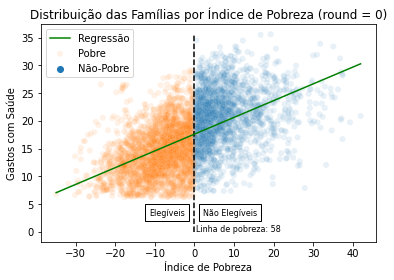

In [17]:
## Plottando
# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)
# Pontos
sns.scatterplot(data=dfTratados0, x='poverty_index_norm', y='health_expenditures', hue='pobre', alpha=0.1)
# Linha
sns.lineplot(data=dfTratados0, x='poverty_index_norm', y='previsoes_simples0', ci=None, color='green', legend=False)
# Linha vertical pontilhada
plt.vlines(x=0, ymin=0, ymax=dfTratados0['health_expenditures'].max(), linestyles='dashed')
# Títulos
plt.title("Distribuição das Famílias por Índice de Pobreza (round = 0)")
plt.xlabel("Índice de Pobreza")
plt.ylabel("Gastos com Saúde")
# Anotações
plt.annotate("Elegíveis", xy=(-7, 3), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate("Não Elegíveis", xy=(9, 3), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(0.5, 0), fontsize=8)
# Legenda
plt.legend(title='', loc='upper left', labels=['Regressão', 'Pobre', 'Não-Pobre'])

##### **Período de Acompanhamento**

In [18]:
## Criando o modelo
modelo_simples1 = ols(formula_simples, dfTratados1).fit(cov_type='HC2', use_t=True)

print(modelo_simples1.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.261
Model:                             OLS   Adj. R-squared:                  0.261
Method:                  Least Squares   F-statistic:                     1404.
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):          9.60e-271
Time:                         23:21:19   Log-Likelihood:                -18777.
No. Observations:                 4960   AIC:                         3.756e+04
Df Residuals:                     4958   BIC:                         3.757e+04
Df Model:                            1                                         
Covariance Type:                   HC2                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.8

In [19]:
## Pegando os valores preditos
dfTratados1["previsoes_simples1"] = modelo_simples1.fittedvalues

(0.0, 40.0)

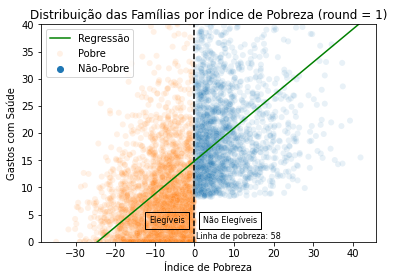

In [20]:
## Plottando
# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)
# Pontos
sns.scatterplot(data=dfTratados1, x='poverty_index_norm', y='health_expenditures', hue='pobre', alpha=0.1)
# Linha
sns.lineplot(data=dfTratados1, x='poverty_index_norm', y='previsoes_simples1', ci=None, color='green', legend=False)
# Linha vertical pontilhada
plt.vlines(x=0, ymin=0, ymax=40, linestyles='dashed')
# Títulos
plt.title("Distribuição das Famílias por Índice de Pobreza (round = 1)")
plt.xlabel("Índice de Pobreza")
plt.ylabel("Gastos com Saúde")
# Anotações
plt.annotate("Elegíveis", xy=(-7, 3.5), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate("Não Elegíveis", xy=(9, 3.5), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(.5, 0.5), fontsize=8)
# Legenda
plt.legend(title='', loc='upper left', labels=['Regressão', 'Pobre', 'Não-Pobre'])
# Limitando o eixo y
plt.ylim(0, 40)

## Dá pra ver claramente uma descotinuidade agora nos pontos! Além disso, a reta ficou bem mais inclinada

#### **RDD**

##### Período-Base

In [28]:
## Modelo de RDD 
formula_rdd = f'health_expenditures ~ poverty_index_norm + enrolled + poverty_index_norm:enrolled'
formula_rdd = f"health_expenditures ~ poverty_index_norm + enrolled"

modelo_rdd0 = ols(formula_rdd, dfTratados0).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados0['locality_identifier']}
)

print(modelo_rdd0.summary())

## Atenção: mesmo que poverty_index se torne insignificante, não poderíamos tirá-la
## do modelo, uma vez que ela é altamente correlacionada com pobre e, consequentemente,
## sua retirada criaria viés de variável omitida

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.352
Model:                             OLS   Adj. R-squared:                  0.352
Method:                  Least Squares   F-statistic:                     444.7
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           3.43e-50
Time:                         23:35:10   Log-Likelihood:                -14491.
No. Observations:                 4959   AIC:                         2.899e+04
Df Residuals:                     4956   BIC:                         2.901e+04
Df Model:                            2                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             19.3

In [29]:
## Pegando os valores previstos
dfTratados0["previsoes_rdd0"] = modelo_rdd0.fittedvalues

Text(0.5, 0, 'Linha de pobreza: 58')

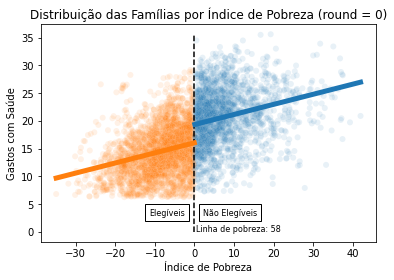

In [30]:
## Plottando
# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)
# Pontos
sns.scatterplot(data=dfTratados0, x='poverty_index_norm', y='health_expenditures', hue='pobre', alpha=0.1, legend=False)
# Linha
sns.lineplot(data=dfTratados0, x='poverty_index_norm', y='previsoes_rdd0', ci=None, hue='pobre', legend=False, lw=5)

# Linha vertical pontilhada
plt.vlines(x=0, ymin=0, ymax=dfTratados0['health_expenditures'].max(), linestyles='dashed')
# Títulos
plt.title("Distribuição das Famílias por Índice de Pobreza (round = 0)")
plt.xlabel("Índice de Pobreza")
plt.ylabel("Gastos com Saúde")
# Anotações
plt.annotate("Elegíveis", xy=(-7, 3), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate("Não Elegíveis", xy=(9, 3), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(0.5, 0), fontsize=8)

##### Período de Acompanhamento

In [31]:
## Modelo
modelo_rdd1 = ols(formula_rdd, dfTratados1).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados1['locality_identifier']}
)

print(modelo_rdd1.summary())

## Sem mais controles, o programa seria responsável por uma queda de US$ 11 por pessoa por ano nos gastos com saúde

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.338
Model:                             OLS   Adj. R-squared:                  0.338
Method:                  Least Squares   F-statistic:                     1033.
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           4.74e-67
Time:                         23:35:29   Log-Likelihood:                -18504.
No. Observations:                 4960   AIC:                         3.701e+04
Df Residuals:                     4957   BIC:                         3.703e+04
Df Model:                            2                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             20.7

In [25]:
## Valores Previstos
dfTratados1["previsoes_rdd1"] = modelo_rdd1.fittedvalues

(0.0, 40.0)

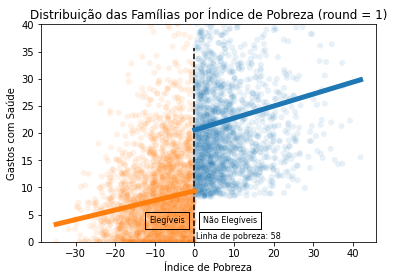

In [26]:
## Plottando
# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200, tight_layout=True)
# Pontos
sns.scatterplot(data=dfTratados1, x='poverty_index_norm', y='health_expenditures', hue='pobre', alpha=0.1, legend=False)
# Linha
sns.lineplot(data=dfTratados1, x='poverty_index_norm', y='previsoes_rdd1', ci=None, hue='pobre', legend=False, lw=5)

# Linha vertical pontilhada
plt.vlines(x=0, ymin=0, ymax=dfTratados0['health_expenditures'].max(), linestyles='dashed')
# Títulos
plt.title("Distribuição das Famílias por Índice de Pobreza (round = 1)")
plt.xlabel("Índice de Pobreza")
plt.ylabel("Gastos com Saúde")
# Anotações
plt.annotate("Elegíveis", xy=(-7, 3.5), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate("Não Elegíveis", xy=(9, 3.5), bbox=dict(facecolor='none', edgecolor='black'), ha='center', fontsize=8)
plt.annotate(f"Linha de pobreza: {nPobreza}", xy=(0.5, 0.5), fontsize=8)

## Limitando o eixo y
plt.ylim(0, 40)

In [32]:
## Adicionando mais controles
# Formula
formula_rdd_completa = f"{formula_rdd} + {sControles}"

# Modelo
modelo_rdd_completo = ols(formula_rdd_completa, dfTratados1).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados1['locality_identifier']}
)
print(modelo_rdd_completo.summary())

## O programa é responsável por uma queda de US$ 9,03 por pessoa por ano nos gastos com saúde
# (lembre-se: seleção aleatória foi de US$ 10, VI foi de US$ 9.5)
# A diferença se dá porque US$ 9,03 é o efeito sobre domicílios PRÓXIMOS do limiar de pobreza,
# enquanto o de VI se aplica a todos do grupo "Participa se for Encorajado".
# Já os resultados de seleção aleatória se aplicam a toda a população.

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.456
Model:                             OLS   Adj. R-squared:                  0.454
Method:                  Least Squares   F-statistic:                     224.9
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           2.74e-67
Time:                         23:36:28   Log-Likelihood:                -18018.
No. Observations:                 4960   AIC:                         3.606e+04
Df Residuals:                     4946   BIC:                         3.615e+04
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.0

### Restringindo a análise em torno do ponto de corte

In [42]:
## Podemos restringir nossos dados em torno do ponto de corte para ter uma estimativa mais acurada do LATE
dfTratados0['poverty_index_norm_abs'] = np.abs(dfTratados0['poverty_index_norm'])
dfTratados1['poverty_index_norm_abs'] = np.abs(dfTratados1['poverty_index_norm'])

dfTratados1Raio5 = dfTratados1.query('poverty_index_norm_abs <= 5')

#### Toda a amostra

In [53]:
## Modelo - Pós Acompanhamento
modelo_rdd_completo_todomundo = ols(formula_rdd_completa, dfTratados1).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados1['locality_identifier']}
)
print(modelo_rdd_completo_todomundo.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.456
Model:                             OLS   Adj. R-squared:                  0.454
Method:                  Least Squares   F-statistic:                     224.9
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           2.74e-67
Time:                         23:54:37   Log-Likelihood:                -18018.
No. Observations:                 4960   AIC:                         3.606e+04
Df Residuals:                     4946   BIC:                         3.615e+04
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.0

In [54]:
## Modelo - Pré Acompanhamento
modelo_rdd_completo_todomundo_periodobase = ols(formula_rdd_completa, dfTratados0).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados0['locality_identifier']}
)
print(modelo_rdd_completo_todomundo_periodobase.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.967
Model:                             OLS   Adj. R-squared:                  0.967
Method:                  Least Squares   F-statistic:                     8179.
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):          9.03e-144
Time:                         23:54:59   Log-Likelihood:                -7078.5
No. Observations:                 4959   AIC:                         1.418e+04
Df Residuals:                     4945   BIC:                         1.428e+04
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.8

#### Raio 5

In [43]:
## Modelo (raio 5)
modelo_rdd_completo_raio5 = ols(formula_rdd_completa, dfTratados1Raio5).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados1Raio5['locality_identifier']}
)
print(modelo_rdd_completo_raio5.summary())

## Prefere-se os resultados com dados mais próximos à linha de corte, mas há um tradeoff em termos de significância estatística (número de observações)
# (vide queda da estatística t e perda de significância de outras variáveis)

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.406
Model:                             OLS   Adj. R-squared:                  0.402
Method:                  Least Squares   F-statistic:                     93.64
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           9.58e-47
Time:                         23:46:33   Log-Likelihood:                -6840.8
No. Observations:                 1879   AIC:                         1.371e+04
Df Residuals:                     1865   BIC:                         1.379e+04
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             30.2

In [46]:
## Raio 5 (período base)
dfTratados0Raio5 = dfTratados0.query('poverty_index_norm_abs <= 5')

## Modelo
modelo_rdd_completo_raio5_periodobase = ols(formula_rdd_completa, dfTratados0Raio5).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados0Raio5['locality_identifier']}
)
print(modelo_rdd_completo_raio5_periodobase.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.958
Model:                             OLS   Adj. R-squared:                  0.958
Method:                  Least Squares   F-statistic:                     5369.
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):          3.44e-125
Time:                         23:46:59   Log-Likelihood:                -2720.9
No. Observations:                 1879   AIC:                             5470.
Df Residuals:                     1865   BIC:                             5547.
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.5

#### Raio 1

In [44]:
## Modelo (raio 1)
# Filtrando os dados pós-acompanhamento
dfTratados1Raio1 = dfTratados1.query('poverty_index_norm_abs <= 1')

# Modelo
modelo_rdd_completo_raio1 = ols(formula_rdd_completa, dfTratados1Raio1).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados1Raio1['locality_identifier']}
)
print(modelo_rdd_completo_raio1.summary())

## Com raio = 5, o efeito cai para -8.61 (significante)
## Com raio = 1, o efeito cai para -7.66 (significante)

## Prefere-se os resultados com dados mais próximos à linha de corte, mas há um tradeoff em termos de significância estatística (número de observações)
# (vide queda da estatística t e perda de significância de outras variáveis)

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.432
Model:                             OLS   Adj. R-squared:                  0.409
Method:                  Least Squares   F-statistic:                     36.77
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           1.56e-26
Time:                         23:46:38   Log-Likelihood:                -1162.6
No. Observations:                  334   AIC:                             2353.
Df Residuals:                      320   BIC:                             2407.
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.5

In [47]:
## Raio 1 (período base)
dfTratados0Raio5 = dfTratados0.query('poverty_index_norm_abs <= 1')

## Modelo
modelo_rdd_completo_raio1_periodobase = ols(formula_rdd_completa, dfTratados0Raio5).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados0Raio5['locality_identifier']}
)
print(modelo_rdd_completo_raio1_periodobase.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.962
Model:                             OLS   Adj. R-squared:                  0.960
Method:                  Least Squares   F-statistic:                     1663.
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           1.15e-83
Time:                         23:47:18   Log-Likelihood:                -462.01
No. Observations:                  334   AIC:                             952.0
Df Residuals:                      320   BIC:                             1005.
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             25.3

#### Raio 0.5

In [48]:
## Modelo (raio 0.5)
# Filtrando os dados pós-acompanhamento
dfTratados1Raio05 = dfTratados1.query('poverty_index_norm_abs <= 0.5')

# Modelo
modelo_rdd_completo_raio05 = ols(formula_rdd_completa, dfTratados1Raio05).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados1Raio05['locality_identifier']}
)
print(modelo_rdd_completo_raio05.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.445
Model:                             OLS   Adj. R-squared:                  0.387
Method:                  Least Squares   F-statistic:                     12.46
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           1.28e-11
Time:                         23:48:07   Log-Likelihood:                -470.61
No. Observations:                  138   AIC:                             969.2
Df Residuals:                      124   BIC:                             1010.
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             29.7

In [49]:
## Modelo (raio 0.5)
dfTratados0Raio05 = dfTratados0.query('poverty_index_norm_abs <= 0.5')

# Modelo
modelo_rdd_completo_raio05_periodobase = ols(formula_rdd_completa, dfTratados0Raio05).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfTratados0Raio05['locality_identifier']}
)
print(modelo_rdd_completo_raio05_periodobase.summary())

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.967
Model:                             OLS   Adj. R-squared:                  0.964
Method:                  Least Squares   F-statistic:                     516.0
Date:                 Tue, 09 Nov 2021   Prob (F-statistic):           2.66e-49
Time:                         23:48:44   Log-Likelihood:                -171.48
No. Observations:                  138   AIC:                             371.0
Df Residuals:                      124   BIC:                             411.9
Df Model:                           13                                         
Covariance Type:               cluster                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             24.5

# Obrigado!